# 66-方向梯度直方图（HOG）第一步：梯度幅值・梯度方向

求 HOG 特征量的梯度幅值和梯度方向

HOG（Histogram of Oriented Gradients）是一种表示图像特征量的方法。特征量是表示图像的状态等的向量集合。

在图像识别（图像是什么）和检测（物体在图像中的哪个位置）中，我们需要：

1. 从图像中获取特征量（特征提取）；
2. 基于特征量识别和检测（识别和检测）。

由于深度学习通过机器学习自动执行特征提取和识别，所以看不到 HOG，但在深度学习变得流行之前，HOG 经常被用作特征量表达。

通过以下算法获得HOG：

1. 图像灰度化之后，在x方向和y方向上求出亮度的梯度：

$x$方向： $$ g_x=I(x+1,y)-I(x-1,y) $$

$y$方向： $$ g_y=I(x,y+1)-I(x,y-1) $$

2. 从$g_x$和$g_y$确定梯度幅值和梯度方向：

梯度幅值：$$ mag=\sqrt{{g_x}^2+{g_y}^2} $$

梯度方向： $$ ang=\arctan{\frac{g_y}{g_x}} $$

3. 将梯度方向$[0,180]$进行9等分量化。也就是说，对于$[0,20]$量化为 index 0，对于$[20,40]$量化为 index 1……

4. 将图像划分为$N \times N$个区域（该区域称为 cell），并作出 cell 内步骤3得到的 index 的直方图。

5. C x C个 cell 被称为一个 block。对每个 block 内的 cell 的直方图通过下面的式子进行归一化。由于归一化过程中窗口一次移动一个 cell 来完成的，因此一个 cell 会被归一化多次，通常$\epsilon=1$： $$ h(t)=\frac{h(t)}{\sqrt{\sum\ h(t)+\epsilon}} $$

以上，求出 HOG 特征值。

这一问，我们完成步骤1到3。

为了使示例答案更容易看出效果，gra是彩色的。此外，mag被归一化至$[0,255]$。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
img = cv2.imread('../picture/chans.png').astype(np.float32)

In [38]:
def RGB2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        return gray

In [20]:
# 1.求亮度梯度
def get_grad(gray):
        
    H, W = gray.shape

    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:H+1, 2:] - gray[1:H+1, :W]
    gy = gray[2:, 1:W+1] - gray[:H, 1:W+1]
    gx[gx == 0] = 1e-6

    return gx, gy

In [21]:
# 2.确定梯度方向和梯度幅值
def get_MagGrag(gx, gy):
        
    magnitude = np.sqrt(gx ** 2 + gy ** 2)
        
    gradient = np.arctan(gy / gx)

    gradient[gradient < 0] = np.pi / 2 + gradient[gradient < 0] + np.pi / 2

    return magnitude, gradient

In [22]:
 # 3.量化
def quantization(gradient):
        
    gradient_quantized = np.zeros_like(gradient, dtype=np.int)

    d = np.pi / 9
        
    for i in range(9):
        gradient_quantized[np.where((gradient >= d * i) & (gradient <= d * (i + 1)))] = i

    return gradient_quantized

In [23]:
# 进行1 2 3 步骤

def HOG_step1(img):
    
    gray = RGB2GRAY(img)
    
    gx, gy = get_grad(gray)
    
    magnitude, gradient = get_MagGrag(gx, gy)
    
    gradient_quantized = quantization(gradient)
    
    return magnitude, gradient_quantized

In [24]:
magnitude, gradient_quantized = HOG_step1(img)

In [25]:
# 归一化梯度至 [0,255]

_magnitude = (magnitude / magnitude.max() * 255).astype(np.uint8)

In [26]:
H, W, C = img.shape
out = np.zeros((H, W, 3), dtype=np.uint8)

In [27]:
# 定义颜色
C = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255],
     [127, 127, 0], [127, 0, 127], [0, 127, 127]]

In [28]:
# 是梯度图像展示为有颜色的

for i in range(9):
     out[gradient_quantized == i] = C[i]

In [29]:
cv2.imwrite("../picture/result66_mag.jpg", _magnitude)
cv2.imwrite("../picture/result66_gra.jpg", out)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 67-方向梯度直方图（HOG）第二步：梯度直方图

取$N=8$，$8 \times 8$个像素为一个 cell，将每个 cell 的梯度幅值加到梯度方向的index处

解答为按照下面的顺序排列索引对应的直方图： $$ \begin{matrix} 1&2& 3\ 4& 5& 6\ 7& 8 &9 \end{matrix} $$

In [30]:
# 4.直方图

def grad_histogram(gradient_quantized, magnitude, N=8):
        
        H, W = magnitude.shape

        cell_N_H = H // N
        cell_N_W = W // N
        histogram = np.zeros((cell_N_H, cell_N_W, 9), dtype=np.float32)

        for y in range(cell_N_H):
            for x in range(cell_N_W):
                for j in range(N):
                    for i in range(N):
                        histogram[y, x, gradient_quantized[y * 4 + j, x * 4 + i]] += magnitude[y * 4 + j, x * 4 + i]

        return histogram

In [31]:
# 进行1 2 3 4 步骤

def HOG_step2(img):
    
    gray = RGB2GRAY(img)
    
    gx, gy = get_grad(gray)
    
    magnitude, gradient = get_MagGrag(gx, gy)
    
    gradient_quantized = quantization(gradient)
    
    histogram = grad_histogram(gradient_quantized, magnitude, N=8)
    
    return histogram

In [32]:
histogram = HOG_step2(img)

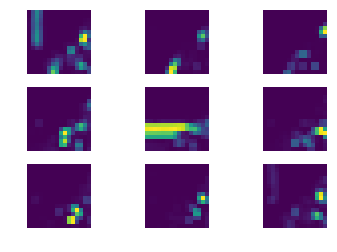

In [33]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(histogram[..., i])
    plt.axis('off')
    plt.xticks(color="None")
    plt.yticks(color="None")
    
plt.savefig("../picture/result67_hist.jpg")
plt.show()

# 68-方向梯度直方图（HOG）第三步：直方图归一化

取$C=3$，将$3\times 3$个 cell 看作一个 block，进行直方图归一化，通常$\epsilon=1$： $$ h(t)=\frac{h(t)}{\sqrt{\sum\ h(t)+\epsilon}} $$ 在此，得到HOG特征量

In [34]:
# 5.直方图归一化

def normalization(histogram, C=3, epsilon=1):
    
        cell_N_H, cell_N_W, _ = histogram.shape
        
        for y in range(cell_N_H):
            for x in range(cell_N_W):
                histogram[y, x] /= np.sqrt(np.sum(histogram[max(y - 1, 0) : min(y + 2, cell_N_H), max(x - 1, 0) : min(x + 2, cell_N_W)] ** 2) + epsilon)

        return histogram

In [45]:
def HOG_step3(img):
    
    gray = RGB2GRAY(img)

    gx, gy = get_grad(gray)

    magnitude, gradient = get_MagGrag(gx, gy)

    gradient_quantized = quantization(gradient)

    histogram = grad_histogram(gradient_quantized, magnitude)
    
    histogram = normalization(histogram)

    return histogram

In [46]:
histogram = HOG_step3(img)

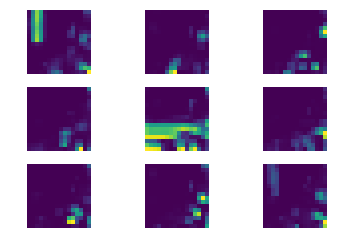

In [47]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(histogram[..., i])
    plt.axis('off')
    plt.xticks(color="None")
    plt.yticks(color="None")
    
plt.savefig("../picture/result67_hist.jpg")
plt.show()

# 69-方向梯度直方图（HOG）第四步：可视化特征量

在这里将得到的特征量可视化。

如果将特征量叠加在灰度化后的图像上，可以很容易看到外形。

一个好的可视化的方法是这样的，为 cell 内的每个 index 的方向画一条线段，并且值越大，线段越白，值越小，线段越黑。

In [51]:
def draw_HOG(img, histogram):

    def draw(gray, histogram, N=8):

        H, W = gray.shape
        cell_N_H, cell_N_W, _ = histogram.shape
        
        out = gray[1 : H + 1, 1 : W + 1].copy().astype(np.uint8)

        for y in range(cell_N_H):
            for x in range(cell_N_W):
                cx = x * N + N // 2
                cy = y * N + N // 2
                x1 = cx + N // 2 - 1
                y1 = cy
                x2 = cx - N // 2 + 1
                y2 = cy
                
                h = histogram[y, x] / np.sum(histogram[y, x])
                h /= h.max()
        
                for c in range(9):
                
                    # angle = (20 * c + 10 - 90) / 180. * np.pi
                    # get angle
                    angle = (20 * c + 10) / 180. * np.pi
                    rx = int(np.sin(angle) * (x1 - cx) + np.cos(angle) * (y1 - cy) + cx)
                    ry = int(np.cos(angle) * (x1 - cx) - np.cos(angle) * (y1 - cy) + cy)
                    lx = int(np.sin(angle) * (x2 - cx) + np.cos(angle) * (y2 - cy) + cx)
                    ly = int(np.cos(angle) * (x2 - cx) - np.cos(angle) * (y2 - cy) + cy)

                    # color is HOG value
                    c = int(255. * h[c])

                    # draw line
                    cv2.line(out, (lx, ly), (rx, ry), (c, c, c), thickness=1)

        return out
    
    gray = RGB2GRAY(img)

    # draw HOG
    out = draw(gray, histogram)

    return out

In [52]:
out = draw_HOG(img, histogram)

In [53]:
cv2.imwrite("../picture/result69_drawHOG.jpg", out)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()